In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [190]:
def parse_section(lines, z1, restrict=True):
    ds = []
    ehf = []
    ecas = []
    first = True
    for line in lines:
        if 'WARNING' in line or 'MAXIMUM NUMBER OF ITERATIONS REACHED' in line:
            return []
        if 'SETTING' not in line:
            continue
        prop = line.strip().split()[1]
        if prop == 'DVAL':
            ds.append(float(line.strip().split()[3]))
            Enn = z1*(14-z1)/(ds[-1]*1.8897161646321)
            first = True
            continue
        if prop.startswith('EHF'):
            ehf.append(float(line.strip().split()[3]) + Enn)
            continue
        if prop.startswith('ECASSCF'):
            if True:
                ecas.append(float(line.strip().split()[3]) + Enn)
                first = False
            continue
    if restrict:
        return [{'d': ds[0], 'hf': ehf[0], 'casscf': sum(ecas)/len(ecas)}]
    else:
        return [{'d': ds, 'hf': ehf, 'casscf': ecas}]

def split_sections(lines):
    sections = []
    section = []
    for line in lines:
        #if "PROGRAM * RHF-SCF (CLOSED SHELL)" in line:
        if "SETTING DVAL" in line:
            sections.append(section)
            section = []
        section.append(line)
    sections.append(section)
    return sections

def parse_file(z1):
    fn = 'nonoise-casscf/%3.1f/pc.out' % z1
    lines = open(fn).readlines()
    sections = split_sections(lines)
    res = []
    for section in sections[1:-1]:
        try:
            res += parse_section(section, z1)
        except:
            raise
    df = pd.DataFrame(res)
    df['z1'] = z1
    df['z2'] = 14-z1
    return df

dfs = []
for z1 in np.arange(2,7.2,0.2):
    dfs.append(parse_file(z1))
df = pd.concat(dfs).reset_index()

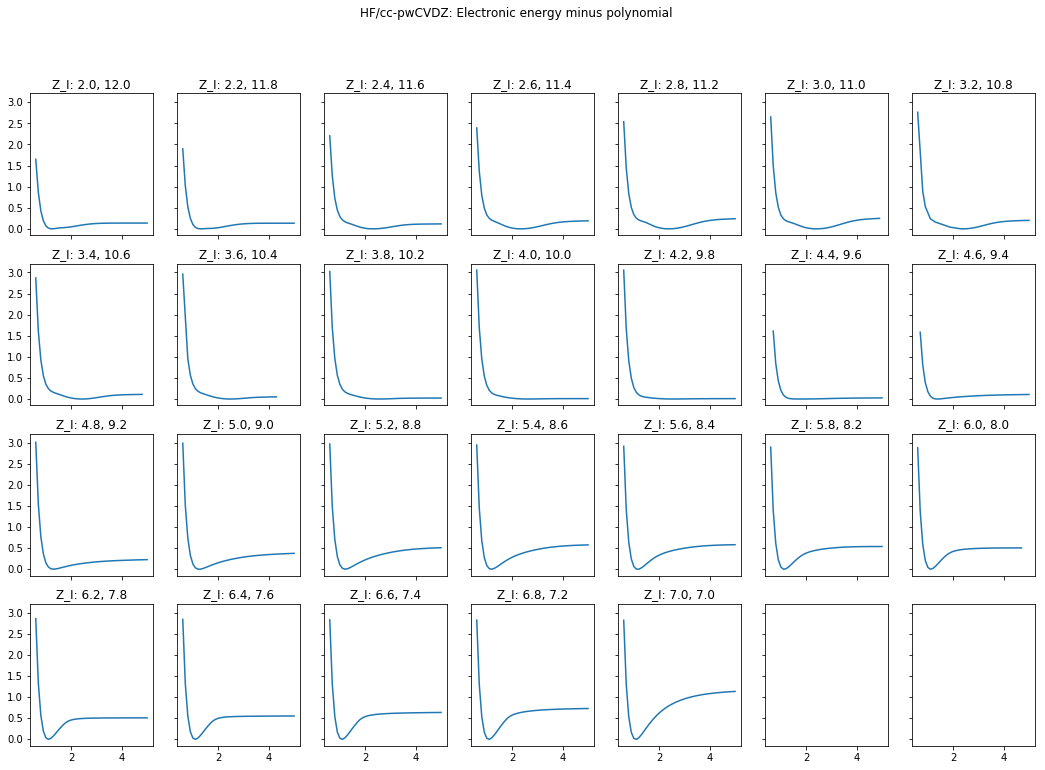

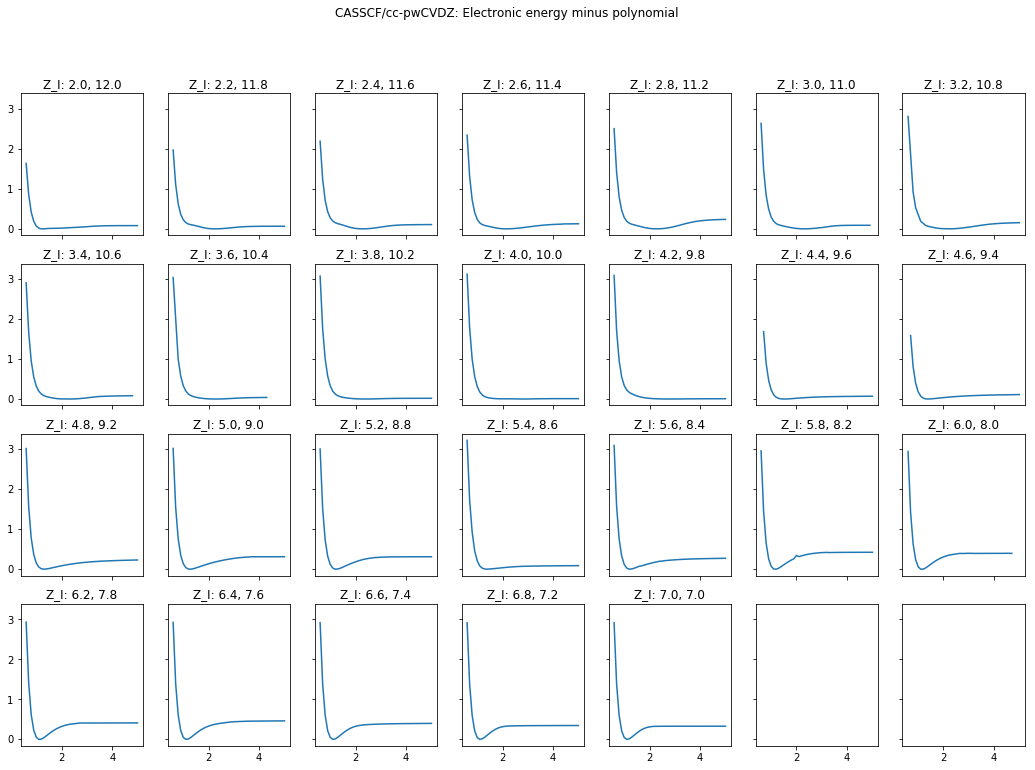

In [202]:
def build_vis(method, label):
    z1 = sorted(df.z1.unique())
    f, axs = plt.subplots(4,7, figsize=(18,12), sharex=True, sharey=True)
    #f, axs = plt.subplots(1,2, figsize=(18,12), sharex=True, sharey=True)
    for zidx, z in enumerate(z1):
    #for zidx, z in enumerate((z1[0],)):
        s = df.query('z1 == @z')
        row = zidx//7
        col = zidx - row*7
        values = s[method].values
        ax = axs[row, col]
        #ax = axs[0]
        ax.plot(s.d, values - min(values), '-', color='C0')
        #axs[row, col].scatter(s.d, values - p(s.d.values), color='C0', s=4)
        ax.set_title('Z_I: %3.1f, %3.1f' % (z, 14-z))
    plt.suptitle('%s: Electronic energy minus polynomial' % label)
    plt.savefig('electronic-dscan-%s.pdf' % method, bbox_inches='tight')
build_vis('hf', 'HF/cc-pwCVDZ')
build_vis('casscf', 'CASSCF/cc-pwCVDZ')

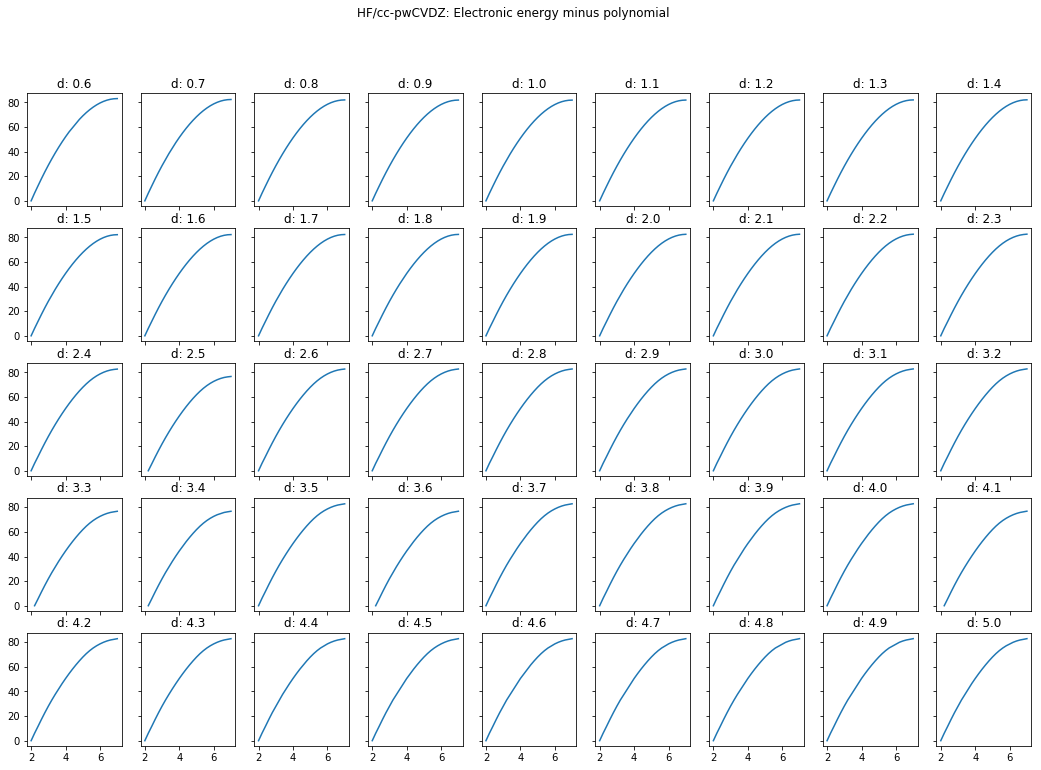

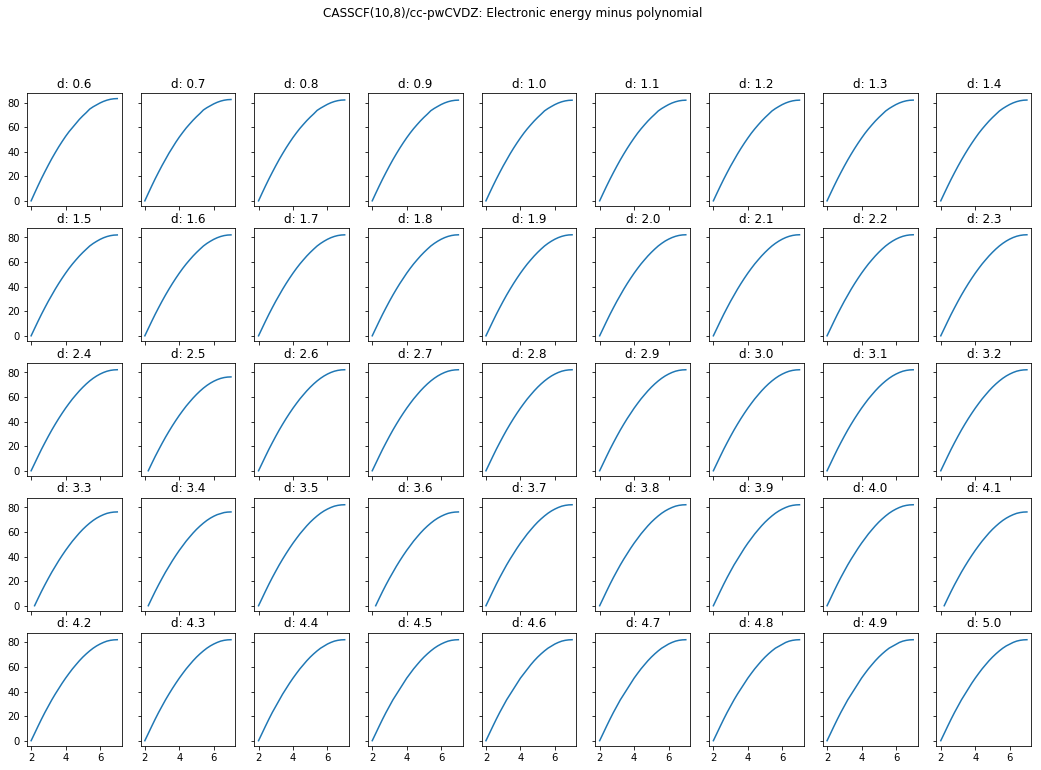

In [203]:
def build_vis(method, label):
    d = sorted(df.d.unique())
    f, axs = plt.subplots(5,9, figsize=(18,12), sharex=True, sharey=True)
    for zidx, d in enumerate(d):
        s = df.query('d == @d')
        row = zidx//9
        col = zidx - row*9
        values = s[method].values
        axs[row, col].plot(s.z1, values-min(values), '-', color='C0')
        axs[row, col].set_title('d: %3.1f' % d)
    plt.suptitle('%s: Electronic energy minus polynomial' % label)
    plt.savefig('electronic-zscan-%s.pdf' % method, bbox_inches='tight')
build_vis('hf', 'HF/cc-pwCVDZ')
build_vis('casscf', 'CASSCF(10,8)/cc-pwCVDZ')

In [197]:
del df['index']

In [201]:
df.to_csv('hf+casscf.txt')